# Spam Email Detection

This notebook implements two approaches for spam email classification:
1. **LSTM-based approach** - A lightweight recurrent neural network
2. **BERT Transformer approach** - A fine-tuned pre-trained transformer model

## Dataset
The dataset contains labeled email data with `ham` (legitimate) and `spam` categories.

---
# Part 1: Common Setup and Data Loading

In [19]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [20]:
# Load dataset
df = pd.read_csv("./spam_ham_dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
df.head()

Dataset shape: (5171, 4)

Label distribution:
label
ham     3672
spam    1499
Name: count, dtype: int64


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [21]:
# Balance the dataset by undersampling ham to match spam count
ham_df = df[df['label'] == 'ham']
spam_df = df[df['label'] == 'spam']

print(f"Original - Ham: {len(ham_df)}, Spam: {len(spam_df)}")

ham_df = ham_df.sample(n=len(spam_df), random_state=SEED)
final_df = pd.concat([ham_df, spam_df]).reset_index(drop=True)
final_df['label_num'] = final_df['label'].map({'ham': 0, 'spam': 1})

print(f"Balanced dataset size: {len(final_df)}")
print(f"\nBalanced label distribution:")
print(final_df['label'].value_counts())

Original - Ham: 3672, Spam: 1499
Balanced dataset size: 2998

Balanced label distribution:
label
ham     1499
spam    1499
Name: count, dtype: int64


---
# Part 2: LSTM Approach

This approach uses:
- Text preprocessing (stopword removal, punctuation removal)
- Keras Tokenizer for text vectorization
- LSTM neural network for sequence classification

## 2.1 Text Preprocessing for LSTM

In [22]:
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
# nltk.download('stopwords')

# Store stopwords in a set for efficient lookup (O(1) instead of O(n))
stop_words = set(stopwords.words('english'))

def preprocess_text_lstm(text):
    """
    Preprocess text for LSTM model:
    1. Convert to lowercase
    2. Remove stopwords
    3. Remove punctuation
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

# Create a copy for LSTM preprocessing
lstm_df = final_df.copy()
lstm_df['text_processed'] = lstm_df['text'].apply(preprocess_text_lstm)

print("Sample preprocessed text:")
print(f"Original: {lstm_df['text'].iloc[0][:200]}...")
print(f"\nProcessed: {lstm_df['text_processed'].iloc[0][:200]}...")

Sample preprocessed text:
Original: Subject: conoco - big cowboy
darren :
i ' m not sure if you can help me with this , but i don ' t know who else to ask . for april and may , we have gas pathed on deal 133304 to conoco at the gepl b...

Processed: subject conoco  big cowboy darren   sure help   know else ask  april may  gas pathed deal 133304 conoco gepl big cowboy point  conoco saying buy gas  accounted hpl big cowboy gas think paid  1  5 mil ...


## 2.2 Data Preparation for LSTM

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
LSTM_MAX_LENGTH = 100
LSTM_EMBEDDING_DIM = 32
LSTM_UNITS = 16
LSTM_BATCH_SIZE = 32
LSTM_EPOCHS = 20

# Train-test split
train_data_lstm, test_data_lstm, train_labels_lstm, test_labels_lstm = train_test_split(
    lstm_df['text_processed'],
    lstm_df['label'],
    test_size=0.2,
    random_state=SEED
)

# Tokenize text
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(train_data_lstm)

train_sequences_lstm = tokenizer_lstm.texts_to_sequences(train_data_lstm)
test_sequences_lstm = tokenizer_lstm.texts_to_sequences(test_data_lstm)

# Pad sequences
train_sequences_lstm = pad_sequences(train_sequences_lstm, maxlen=LSTM_MAX_LENGTH, padding='post')
test_sequences_lstm = pad_sequences(test_sequences_lstm, maxlen=LSTM_MAX_LENGTH, padding='post')

# Convert labels to numeric
train_labels_lstm = train_labels_lstm.map({'ham': 0, 'spam': 1})
test_labels_lstm = test_labels_lstm.map({'ham': 0, 'spam': 1})

vocab_size = len(tokenizer_lstm.word_index) + 1
print(f"Vocabulary size: {vocab_size}")
print(f"Training samples: {len(train_sequences_lstm)}")
print(f"Test samples: {len(test_sequences_lstm)}")

Vocabulary size: 39846
Training samples: 2398
Test samples: 600


## 2.3 LSTM Model Architecture

In [24]:
# Build LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=LSTM_EMBEDDING_DIM
    ),
    tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=False, use_cudnn=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

lstm_model.summary()

2026-01-28 01:08:26.844153: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.4 Train LSTM Model

In [25]:
# Callbacks
early_stopping = EarlyStopping(
    patience=3,
    monitor='val_accuracy',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    patience=2,
    monitor='val_loss',
    factor=0.5,
    verbose=1
)

# Train the model
print("Training LSTM model...")
print("=" * 60)

lstm_history = lstm_model.fit(
    train_sequences_lstm, train_labels_lstm,
    validation_data=(test_sequences_lstm, test_labels_lstm),
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Training LSTM model...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6439 - loss: 0.6375 - val_accuracy: 0.8450 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9324 - loss: 0.2487 - val_accuracy: 0.9550 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9583 - loss: 0.1880 - val_accuracy: 0.9750 - val_loss: 0.1179 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9258 - loss: 0.2533 - val_accuracy: 0.8900 - val_loss: 0.3144 - learning_rate: 0.0010
Epoch 5/20
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9315 - loss: 0.2209
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9500 - loss: 0.2056 - val_accuracy: 0.9667 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9766 - 

## 2.5 Evaluate LSTM Model

In [26]:
# Evaluate LSTM model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(test_sequences_lstm, test_labels_lstm)
print(f'\nLSTM Test Loss: {lstm_test_loss:.4f}')
print(f'LSTM Test Accuracy: {lstm_test_accuracy:.4f}')

# Get predictions for classification report
lstm_predictions = (lstm_model.predict(test_sequences_lstm) > 0.5).astype(int).flatten()

print("\n" + "=" * 60)
print("Classification Report - LSTM:")
print("=" * 60)
print(classification_report(test_labels_lstm, lstm_predictions, target_names=['ham', 'spam'], digits=4))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9750 - loss: 0.1179

LSTM Test Loss: 0.1179
LSTM Test Accuracy: 0.9750
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report - LSTM:
              precision    recall  f1-score   support

         ham     0.9808    0.9714    0.9761       315
        spam     0.9688    0.9789    0.9738       285

    accuracy                         0.9750       600
   macro avg     0.9748    0.9752    0.9749       600
weighted avg     0.9751    0.9750    0.9750       600



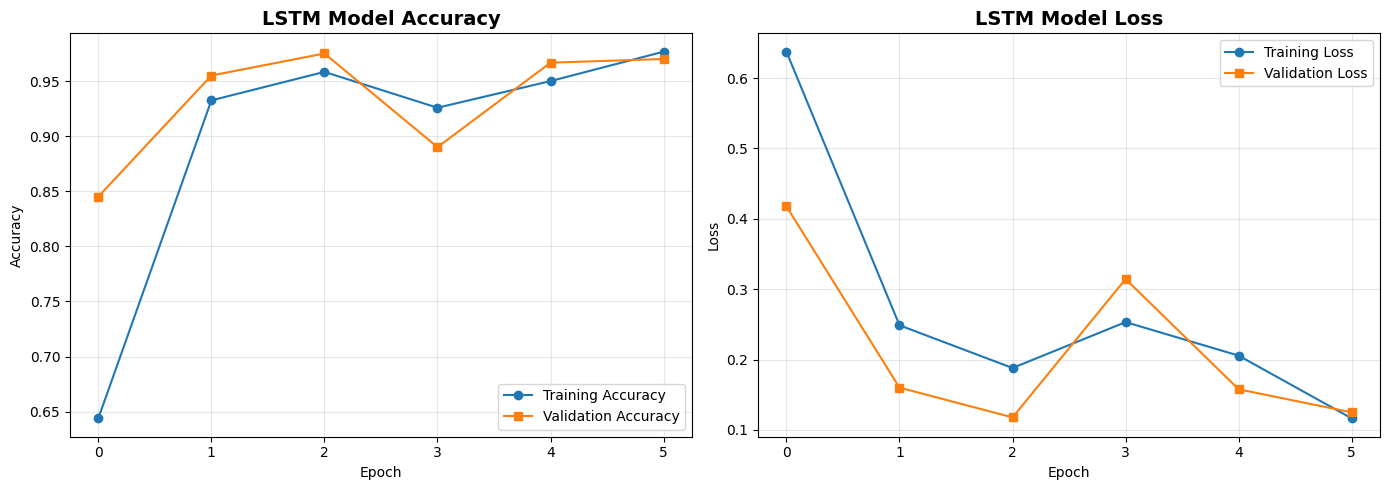

In [27]:
# Plot LSTM training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(lstm_history.history['accuracy'], label='Training Accuracy', marker='o')
ax1.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
ax1.set_title('LSTM Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(lstm_history.history['loss'], label='Training Loss', marker='o')
ax2.plot(lstm_history.history['val_loss'], label='Validation Loss', marker='s')
ax2.set_title('LSTM Model Loss', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

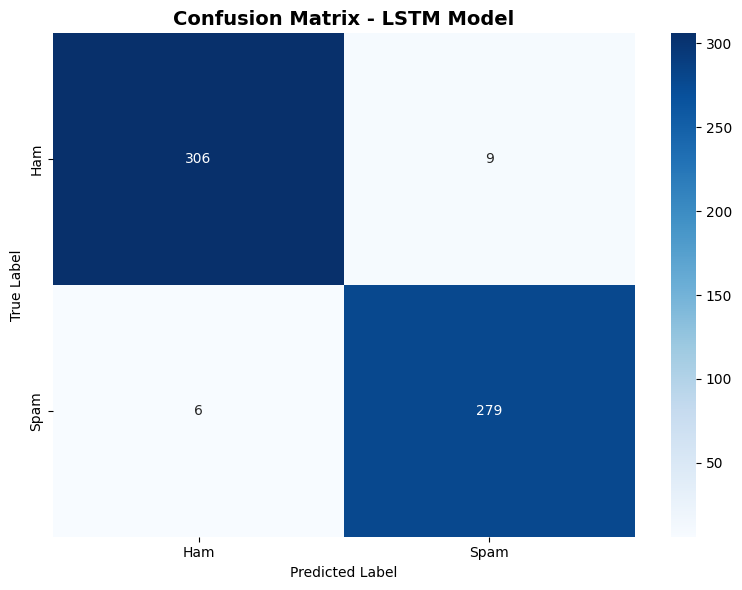

In [28]:
# Confusion Matrix - LSTM
lstm_cm = confusion_matrix(test_labels_lstm, lstm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - LSTM Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
# Part 3: BERT Transformer Approach

This approach uses:
- Pre-trained BERT model for contextualized embeddings
- Fine-tuning with a custom classification head
- No manual text preprocessing (BERT handles tokenization)

## 3.1 Setup for BERT

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for PyTorch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


## 3.2 Data Preparation for BERT

In [30]:
# Hyperparameters for BERT
BERT_MODEL_NAME = 'bert-base-uncased'
BERT_MAX_LENGTH = 128
BERT_BATCH_SIZE = 16
BERT_EPOCHS = 3
BERT_LEARNING_RATE = 2e-5

# Train-test split (using original text, no preprocessing needed for BERT)
train_texts_bert, test_texts_bert, train_labels_bert, test_labels_bert = train_test_split(
    final_df['text'].values,
    final_df['label_num'].values,
    test_size=0.2,
    random_state=SEED,
    stratify=final_df['label_num'].values
)

print(f"Training samples: {len(train_texts_bert)}")
print(f"Test samples: {len(test_texts_bert)}")

Training samples: 2398
Test samples: 600


In [31]:
class SpamDataset(Dataset):
    """Custom Dataset for spam classification with BERT"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize and encode the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Add [CLS] and [SEP] tokens
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [32]:
# Load BERT tokenizer
print(f"Loading tokenizer: {BERT_MODEL_NAME}...")
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# Create datasets
train_dataset_bert = SpamDataset(
    texts=train_texts_bert,
    labels=train_labels_bert,
    tokenizer=bert_tokenizer,
    max_length=BERT_MAX_LENGTH
)

test_dataset_bert = SpamDataset(
    texts=test_texts_bert,
    labels=test_labels_bert,
    tokenizer=bert_tokenizer,
    max_length=BERT_MAX_LENGTH
)

# Create data loaders
train_loader_bert = DataLoader(
    train_dataset_bert,
    batch_size=BERT_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader_bert = DataLoader(
    test_dataset_bert,
    batch_size=BERT_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Number of training batches: {len(train_loader_bert)}")
print(f"Number of test batches: {len(test_loader_bert)}")

Loading tokenizer: bert-base-uncased...
Number of training batches: 150
Number of test batches: 38


## 3.3 BERT Classifier Model

In [33]:
class BERTSpamClassifier(nn.Module):
    """
    BERT-based Spam Classifier
    
    Uses the pre-trained BERT model with a custom classification head.
    The [CLS] token's pooled output is passed through a dropout layer
    and a linear layer for binary classification.
    """
    
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2, dropout=0.3):
        super(BERTSpamClassifier, self).__init__()
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Use pooled output (CLS token representation)
        pooled_output = outputs.pooler_output
        
        # Apply dropout and classification
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        
        return logits

In [34]:
# Initialize BERT model
print(f"Initializing BERT model: {BERT_MODEL_NAME}...")
bert_model = BERTSpamClassifier(
    bert_model_name=BERT_MODEL_NAME,
    num_classes=2,
    dropout=0.3
)
bert_model.to(device)

print(f"Total parameters: {sum(p.numel() for p in bert_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in bert_model.parameters() if p.requires_grad):,}")

Initializing BERT model: bert-base-uncased...
Total parameters: 109,483,778
Trainable parameters: 109,483,778


## 3.4 Training Setup

In [35]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=BERT_LEARNING_RATE)

# Learning rate scheduler with warmup
total_steps = len(train_loader_bert) * BERT_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")

Total training steps: 450


In [36]:
def train_epoch_bert(model, data_loader, criterion, optimizer, device, scheduler):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)
        total_loss += loss.item()
        
        # Update progress bar
        current_acc = correct_predictions.double() / total_samples
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc.item():.4f}'
        })
    
    avg_loss = total_loss / len(data_loader)
    avg_acc = correct_predictions.double() / total_samples
    
    return avg_loss, avg_acc.item()


def eval_model_bert(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Evaluating')
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)
            total_loss += loss.item()
            
            current_acc = correct_predictions.double() / total_samples
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc.item():.4f}'
            })
    
    avg_loss = total_loss / len(data_loader)
    avg_acc = correct_predictions.double() / total_samples
    
    return avg_loss, avg_acc.item(), all_preds, all_labels

## 3.5 Train BERT Model

In [37]:
# Training history
bert_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_accuracy = 0

print("\n" + "=" * 60)
print("Starting BERT Training")
print("=" * 60)

for epoch in range(BERT_EPOCHS):
    print(f'\n{"="*60}')
    print(f'Epoch {epoch + 1}/{BERT_EPOCHS}')
    print(f'{"="*60}')
    
    # Train
    train_loss, train_acc = train_epoch_bert(
        bert_model, train_loader_bert, criterion, optimizer, device, scheduler
    )
    print(f'\nTraining   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    
    # Evaluate
    val_loss, val_acc, val_preds, val_labels = eval_model_bert(
        bert_model, test_loader_bert, criterion, device
    )
    print(f'Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    
    # Save history
    bert_history['train_loss'].append(train_loss)
    bert_history['train_acc'].append(train_acc)
    bert_history['val_loss'].append(val_loss)
    bert_history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_accuracy:
        torch.save({
            'epoch': epoch,
            'model_state_dict': bert_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': val_acc,
            'loss': val_loss
        }, 'best_bert_spam_classifier.pth')
        best_accuracy = val_acc
        print(f'Model saved! (Best Accuracy: {best_accuracy:.4f})')

print(f'\n{"="*60}')
print(f'Training Complete! Best Validation Accuracy: {best_accuracy:.4f}')
print(f'{"="*60}')


Starting BERT Training

Epoch 1/3


Training: 100%|██████████| 150/150 [00:15<00:00,  9.71it/s, loss=0.2864, acc=0.9258]



Training   - Loss: 0.2135, Accuracy: 0.9258


Evaluating: 100%|██████████| 38/38 [00:02<00:00, 15.98it/s, loss=0.0154, acc=0.9833]


Validation - Loss: 0.0549, Accuracy: 0.9833
Model saved! (Best Accuracy: 0.9833)

Epoch 2/3


Training: 100%|██████████| 150/150 [00:15<00:00,  9.70it/s, loss=0.0017, acc=0.9887]



Training   - Loss: 0.0394, Accuracy: 0.9887


Evaluating: 100%|██████████| 38/38 [00:02<00:00, 15.96it/s, loss=0.0502, acc=0.9900]


Validation - Loss: 0.0322, Accuracy: 0.9900
Model saved! (Best Accuracy: 0.9900)

Epoch 3/3


Training: 100%|██████████| 150/150 [00:15<00:00,  9.68it/s, loss=0.0010, acc=0.9983]



Training   - Loss: 0.0074, Accuracy: 0.9983


Evaluating: 100%|██████████| 38/38 [00:02<00:00, 15.93it/s, loss=0.0259, acc=0.9917]


Validation - Loss: 0.0342, Accuracy: 0.9917
Model saved! (Best Accuracy: 0.9917)

Training Complete! Best Validation Accuracy: 0.9917


## 3.6 Evaluate BERT Model

In [38]:
# Load best model for final evaluation
checkpoint = torch.load('best_bert_spam_classifier.pth', weights_only=False)
bert_model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation
bert_test_loss, bert_test_accuracy, bert_predictions, bert_true_labels = eval_model_bert(
    bert_model, test_loader_bert, criterion, device
)

print(f'\nBERT Test Loss: {bert_test_loss:.4f}')
print(f'BERT Test Accuracy: {bert_test_accuracy:.4f}')
print(f'Best Epoch: {checkpoint["epoch"] + 1}')

print("\n" + "=" * 60)
print("Classification Report - BERT:")
print("=" * 60)
print(classification_report(bert_true_labels, bert_predictions, target_names=['ham', 'spam'], digits=4))

Evaluating: 100%|██████████| 38/38 [00:02<00:00, 15.83it/s, loss=0.0259, acc=0.9917]


BERT Test Loss: 0.0342
BERT Test Accuracy: 0.9917
Best Epoch: 3

Classification Report - BERT:
              precision    recall  f1-score   support

         ham     0.9900    0.9933    0.9917       300
        spam     0.9933    0.9900    0.9917       300

    accuracy                         0.9917       600
   macro avg     0.9917    0.9917    0.9917       600
weighted avg     0.9917    0.9917    0.9917       600



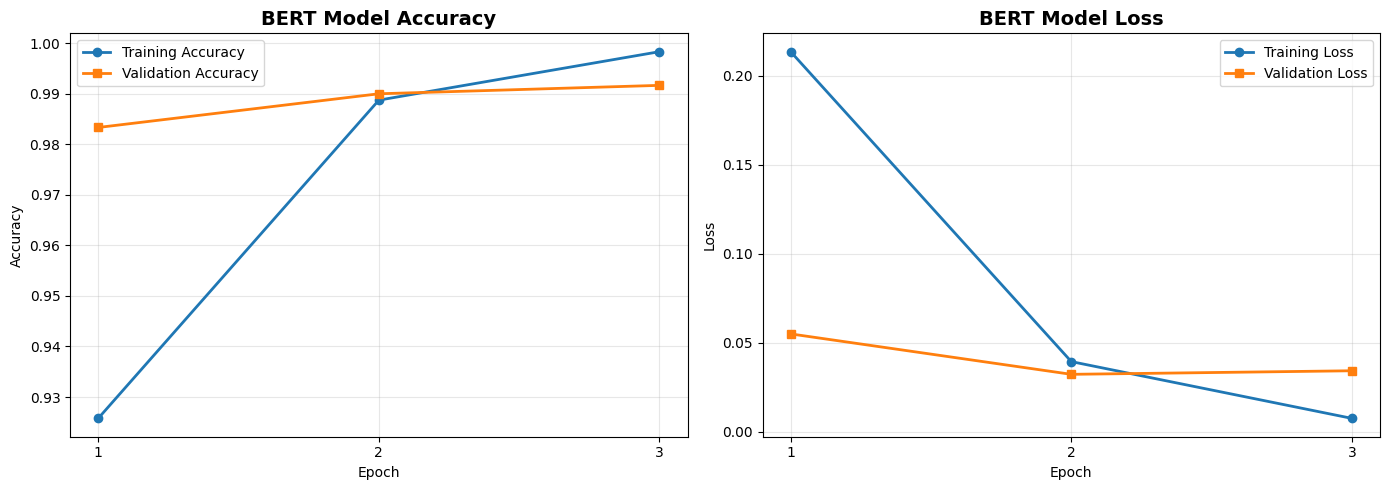

In [39]:
# Plot BERT training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, BERT_EPOCHS + 1)

# Accuracy plot
ax1.plot(epochs_range, bert_history['train_acc'], label='Training Accuracy', marker='o', linewidth=2)
ax1.plot(epochs_range, bert_history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2)
ax1.set_title('BERT Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs_range)

# Loss plot
ax2.plot(epochs_range, bert_history['train_loss'], label='Training Loss', marker='o', linewidth=2)
ax2.plot(epochs_range, bert_history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
ax2.set_title('BERT Model Loss', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs_range)

plt.tight_layout()
plt.show()

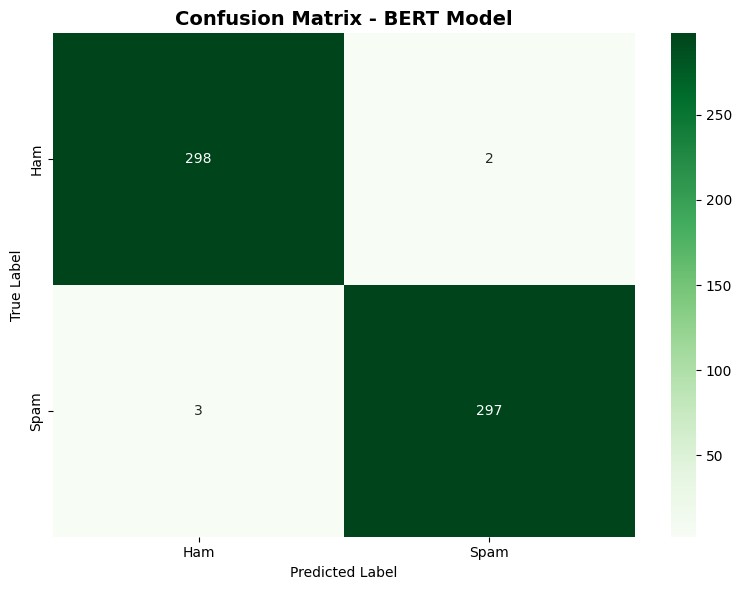

In [40]:
# Confusion Matrix - BERT
bert_cm = confusion_matrix(bert_true_labels, bert_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - BERT Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
# Part 4: Model Comparison

In [41]:
# Model Comparison Summary
print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison_data = {
    'Model': ['LSTM', 'BERT'],
    'Test Accuracy': [f'{lstm_test_accuracy:.4f}', f'{bert_test_accuracy:.4f}'],
    'Test Loss': [f'{lstm_test_loss:.4f}', f'{bert_test_loss:.4f}'],
    'Parameters': ['~50K', '~109M'],
    'Training Time': ['Fast', 'Slower (GPU recommended)'],
    'Preprocessing': ['Required (stopwords, punctuation)', 'None (BERT tokenizer)']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 70)
print("INSIGHTS:")
print("=" * 70)
print("")
print("LSTM: Lightweight model, good for resource-constrained environments")
print("BERT: State-of-the-art performance, requires more computational resources")
print("Both models achieve high accuracy on spam detection task")
print("")

MODEL COMPARISON SUMMARY
Model Test Accuracy Test Loss Parameters            Training Time                     Preprocessing
 LSTM        0.9750    0.1179       ~50K                     Fast Required (stopwords, punctuation)
 BERT        0.9917    0.0342      ~109M Slower (GPU recommended)             None (BERT tokenizer)

INSIGHTS:

LSTM: Lightweight model, good for resource-constrained environments
BERT: State-of-the-art performance, requires more computational resources
Both models achieve high accuracy on spam detection task



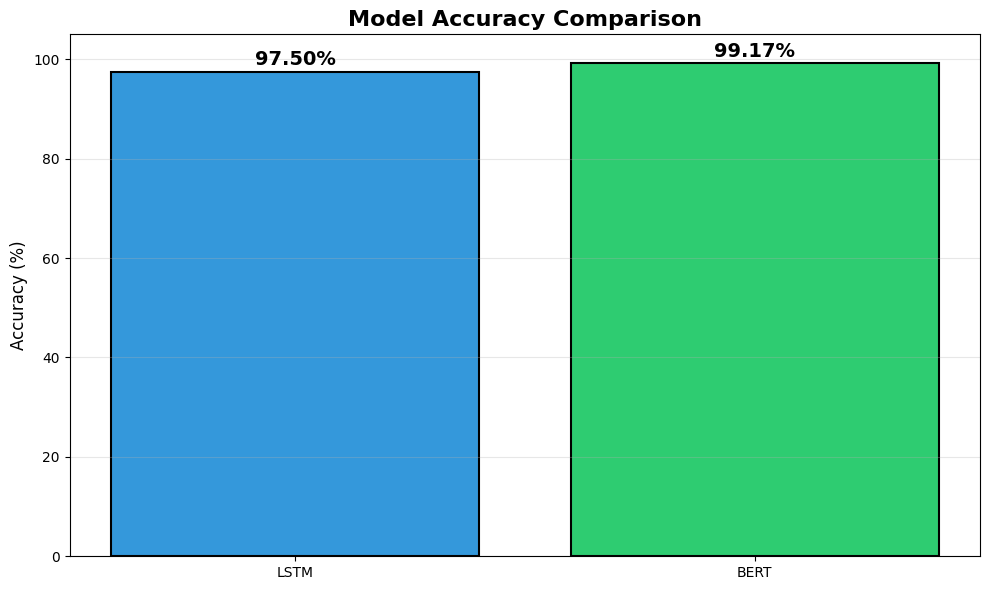

In [42]:
# Visual comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = ['LSTM', 'BERT']
accuracies = [lstm_test_accuracy * 100, bert_test_accuracy * 100]
colors = ['#3498db', '#2ecc71']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part 5: Inference Examples

In [43]:
def predict_spam_lstm(text, model, tokenizer, max_length=100):
    """Predict using LSTM model"""
    # Preprocess
    processed_text = preprocess_text_lstm(text)
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Predict
    prediction = model.predict(padded, verbose=0)[0][0]
    label = 'spam' if prediction > 0.5 else 'ham'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return label, confidence


def predict_spam_bert(text, model, tokenizer, device, max_length=128):
    """Predict using BERT model"""
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1)
    
    label = 'spam' if prediction.item() == 1 else 'ham'
    confidence = probabilities[0][prediction.item()].item()
    
    return label, confidence

In [44]:
# Test samples
test_samples = [
    "Hey, are we still meeting for lunch tomorrow?",
    "WINNER! You've been selected to receive a FREE vacation! Click now!",
    "Can you send me the quarterly report by EOD?",
    "Congratulations! Claim your $1000 prize NOW! Limited time offer!",
    "Meeting postponed to next Tuesday at 3 PM",
    "URGENT: Your account will be closed unless you verify your details immediately!"
]

print("=" * 80)
print("SAMPLE PREDICTIONS")
print("=" * 80 + "\n")

for i, text in enumerate(test_samples, 1):
    lstm_label, lstm_conf = predict_spam_lstm(text, lstm_model, tokenizer_lstm)
    bert_label, bert_conf = predict_spam_bert(text, bert_model, bert_tokenizer, device)
    
    print(f"Sample {i}:")
    print(f"Text: {text}")
    print(f"LSTM Prediction: {lstm_label.upper()} (Confidence: {lstm_conf:.4f})")
    print(f"BERT Prediction: {bert_label.upper()} (Confidence: {bert_conf:.4f})")
    print("-" * 80 + "\n")

SAMPLE PREDICTIONS

Sample 1:
Text: Hey, are we still meeting for lunch tomorrow?
LSTM Prediction: HAM (Confidence: 0.9490)
BERT Prediction: HAM (Confidence: 0.9960)
--------------------------------------------------------------------------------

Sample 2:
Text: WINNER! You've been selected to receive a FREE vacation! Click now!
LSTM Prediction: SPAM (Confidence: 0.9780)
BERT Prediction: SPAM (Confidence: 0.9977)
--------------------------------------------------------------------------------

Sample 3:
Text: Can you send me the quarterly report by EOD?
LSTM Prediction: SPAM (Confidence: 0.9780)
BERT Prediction: HAM (Confidence: 0.9895)
--------------------------------------------------------------------------------

Sample 4:
Text: Congratulations! Claim your $1000 prize NOW! Limited time offer!
LSTM Prediction: SPAM (Confidence: 0.9780)
BERT Prediction: SPAM (Confidence: 0.9988)
--------------------------------------------------------------------------------

Sample 5:
Text: Meeting

---
# Conclusion

This notebook demonstrated two approaches to spam email classification:

1. **LSTM Model**: A lightweight approach using word embeddings and recurrent layers. Good for quick prototyping and resource-constrained environments.

2. **BERT Model**: A transformer-based approach leveraging pre-trained language understanding. Achieves state-of-the-art results but requires more computational resources.

Both models successfully learned to distinguish between spam and legitimate emails with high accuracy.